In [450]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_6'

In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from sklearn.datasets import make_blobs

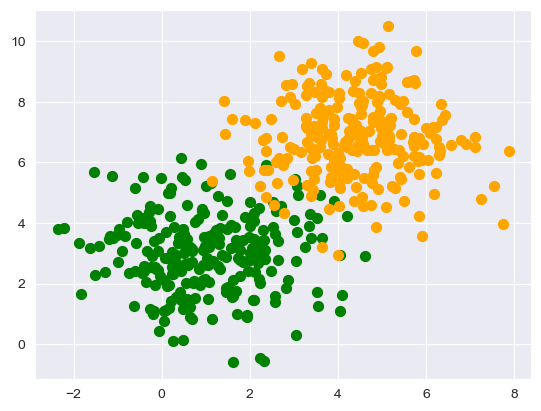

In [452]:
g_n_samples = 500
g_random_state = 0

data, labels = make_blobs(
    n_samples=g_n_samples,
    centers=([1.1, 3], [4.5, 6.9]),
    cluster_std=1.3,
    random_state=g_random_state
)

colours = ('green', 'orange')
fig, ax = plt.subplots()

for n_class in range(2):
    ax.scatter(
        data[labels == n_class][:, 0],
        data[labels == n_class][:, 1],
        c=colours[n_class],
        s=50,
        label=str(n_class)
    )

In [453]:
df = pd.DataFrame(data, columns=['f1', 'f2'])
df['target'] = labels

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      500 non-null    float64
 1   f2      500 non-null    float64
 2   target  500 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 9.9 KB


In [455]:
df.head()

,f1,f2,target
0,6.226118,6.768334,1
1,1.048932,1.481478,0
2,2.873891,2.103716,0
3,-0.780495,4.040387,0
4,4.037102,2.945066,0


In [461]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

In [457]:
class WeightsInit:
    @staticmethod
    def zeroes(n: int, _random_state: float) -> np.ndarray:
        return np.zeros(shape=(n, ))

    @staticmethod
    def random(n: int, random_state: float) -> np.ndarray:
        rng = np.random.default_rng(random_state)
        return rng.uniform(0., 1., n)



class ActivationFunc:
    @staticmethod
    @np.vectorize
    def step(wsum: float) -> float:
        return 1. if wsum > 0. else 0.

    @staticmethod
    @np.vectorize
    def sigmoid(wsum: float) -> float:
        return 1. / (1. + np.exp(-wsum))

    @staticmethod
    @np.vectorize
    def tanh(wsum: float) -> float:
        return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))


class Perceptron:
    def __init__(
        self,
        *,
        weights: Callable = WeightsInit.random,
        activation: Callable = ActivationFunc.step,
        threshold: float = 0.5,
        random_state: int = 0,
        n_epochs: int = 10,
        learning_rate: float = 0.3,
    ):
        self.weights_init = weights
        self.activation_func = activation
        self.threshold = threshold
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state

        self.weights_: np.ndarray = None

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        self.weights_ = self.weights_init(X.shape[1] + 1, self.random_state)

        for epoch in range(self.n_epochs):
            for i, x_i in X.iterrows():
                y_i_pred = self.predict(x_i.to_frame().T)
                x_i_p = np.insert(x_i.values, 0, 1.)
                self.weights_ += self.learning_rate * (y[i] - y_i_pred) * x_i_p

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
        a = self.activation_func(np.dot(X, self.weights_))
        return np.where(a > self.threshold, 1, 0)

    def score(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        return accuracy_score(y, self.predict(X))

In [458]:
model_1 = Perceptron(random_state=g_random_state)
model_1.fit(X_train, y_train)
model_1.weights_

array([-20.96303831,   1.71871583,   2.67304224])

In [459]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        50
           1       1.00      0.82      0.90        50

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



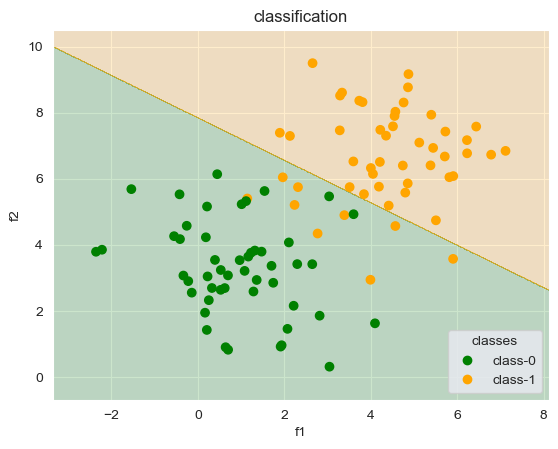

In [460]:
from matplotlib.colors import ListedColormap

mesh_f1, mesh_f2 = np.meshgrid(
    np.linspace(X_test['f1'].min() - 1., X_test['f1'].max() + 1., 1000),
    np.linspace(X_test['f2'].min() - 1., X_test['f2'].max() + 1., 1000)
)

mesh_X_test_data = np.c_[mesh_f1.ravel(), mesh_f2.ravel()]
mesh_X_test = pd.DataFrame(mesh_X_test_data, columns=['f1', 'f2'])
mesh_y_pred = model_1.predict(mesh_X_test).reshape(mesh_f1.shape)

cmap = ListedColormap(colours)

plt.contourf(mesh_f1, mesh_f2, mesh_y_pred, alpha=0.2, cmap=cmap)
scatter = plt.scatter(X_test['f1'], X_test['f2'], c=y_test, cmap=cmap)

plt.xlim(mesh_f1.min(), mesh_f1.max())
plt.ylim(mesh_f2.min(), mesh_f2.max())
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend(
    handles=scatter.legend_elements()[0],
    title='classes',
    labels=['class-0', 'class-1'],
    loc='lower right'
)
plt.title('classification')

plt.show()